In [1]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from typing import TypedDict , Literal
from pydantic import BaseModel, Field
import json
from pprint import pprint

In [2]:
load_dotenv()

True

In [3]:
model=ChatGroq(
    model='llama-3.3-70b-versatile'
)

In [4]:
class LLMCondition(BaseModel):

    sentiment: Literal['Positive','Negative'] =Field(description='Find the sentiment')

In [5]:
struc_model=model.with_structured_output(LLMCondition)

In [6]:
class Graphstate(TypedDict):

    review:str
    sentiment:str
    issue_type:str
    tone_type:str
    urgency_type:str
    positive_response:str
    response:str
    issue_type:str
    tone_type:str
    urgency_type:str

In [7]:
graph=StateGraph(Graphstate)

In [8]:
def sentiment(state:Graphstate):

    prompt=f'find the sentiment of the given review {state['review']}'
    sentiment=struc_model.invoke(prompt)

    return {
        'sentiment':sentiment
    }

In [9]:
def run_diag(state:Graphstate):

    prompt=(
        f"Analyze the following customer review:\n\n"
        f"\"{state['review']}\"\n\n"
        "Identify the following aspects:\n"
        "1. Issue Type (e.g., 'service', 'product', 'delivery', etc.):\n"
        "2. Tone Type (e.g., 'angry', 'frustrated', 'disappointed', etc.):\n"
        "3. Urgency Level (e.g., 'urgent', 'not urgent', 'moderate'):\n\n"
        "Return your answers in this JSON format:\n"
        '{"issue_type": "<value>", "tone_type": "<value>", "urgency_type": "<value>"}'
    )
    
    resp=model.invoke(prompt)

    llm_output=resp.content
    result = json.loads(llm_output)
    issue_type = result["issue_type"]
    tone_type = result["tone_type"]
    urgency_type = result["urgency_type"]

    return {
        'issue_type':issue_type,
        'tone_type':tone_type,
        'urgency_type':urgency_type
    }

In [10]:
def response(state: Graphstate):

    issue_type = state['issue_type']
    tone_type = state['tone_type']
    urgency_type = state['urgency_type']

    prompt = f'''
    You are a helpful customer support assistant.

    Given the following parameters extracted from a customer's review:
    - Issue Type: {issue_type}
    - Tone Type: {tone_type}
    - Urgency Level: {urgency_type}

    Compose a thoughtful, empathetic reply addressing the customer's concerns. 
    - Directly acknowledge the specific issue type.
    - Match the tone and show understanding of the customer's mood.
    - Consider the urgency level when shaping your response—respond more swiftly and formally when urgent, more reassuringly if not urgent.
    - Keep the response clear and courteous.

    Reply as if you are writing to the customer.

    Example format:

    "Thank you for your feedback regarding {issue_type}. We understand that you are feeling {tone_type} about this experience. Our team recognizes the {urgency_type} nature of your concern and will take appropriate action. [Add any further actions, apologies, or solutions relevant to the context.]"

    Return only your composed reply, without explanation or extra formatting.
'''

    final_response = model.invoke(prompt)

    return {
        'response': final_response
    }


In [11]:
def positive_res(state:Graphstate):

    dem='Thank you for your feedback'

    return {
        'positive_response': dem
    }

In [12]:
def conditional_dec(state:Graphstate)-> Literal["positive_res", "run_diag"]:

    if state['sentiment']=='Positive':
        return 'positive_res'

    else:
        return 'run_diag'

In [13]:
graph.add_node('sentiment',sentiment)
graph.add_node('run_diag',run_diag)
graph.add_node('response',response)
graph.add_node('positive_res',positive_res)

graph.add_edge(START,'sentiment')
graph.add_conditional_edges('sentiment', conditional_dec)

graph.add_edge('positive_res',END)

graph.add_edge('run_diag','response')
graph.add_edge('response',END)

In [14]:
workflow=graph.compile()

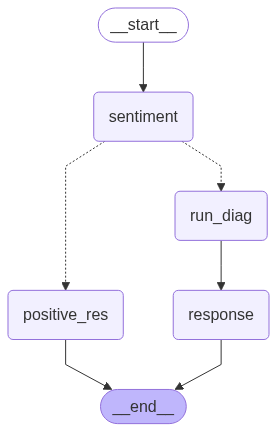

In [15]:
workflow

In [16]:
revi_pos='''I recently bought the Lenovo AI Ryzen 7 350, and I’m really happy with it. The performance is top-notch—the Ryzen 7 processor handles multitasking with ease. I use it for coding, browsing, and occasional gaming, and it runs smoothly without any lag.

The built-in AI features are genuinely helpful. They optimize performance and battery life depending on how I use the laptop, which makes it feel very responsive and efficient.

The display is bright and clear, and the laptop looks sleek and premium. It’s also lightweight, so it’s easy to carry around. The keyboard is comfortable for long typing sessions, and the speakers are clear and loud enough for regular use—I found them quite satisfying.

It has face recognition login, which is a nice feature, but it’s not as fast as I expected. Also, it doesn’t come with a fingerprint sensor, which would have been a great addition.

That said, overall it’s a great value for the price, with solid performance and modern features. I’d definitely recommend it for students, professionals, or anyone needing a reliable, powerful laptop.'''

In [17]:
revi_neg='''

Amazon and Apple Service Centre not replace my MacBook Air M1 after submit in 7 Days Replacement Policy.
my 1 month totally waste for conversation from Amazon support and apple support but product not replace :(
bed experience first time on Amazon.in

The Apple MacBook Air with the M1 Chip is a standout in the laptop market, combining sleek design with breakthrough performance. The shift to Apple’s custom M1 processor is a game-changer, providing blazing-fast speeds, improved battery life, and quiet operation due to the fanless design.

Performance: The M1 chip offers impressive speed and efficiency. Everyday tasks like web browsing, document editing, and streaming are incredibly smooth, and even more demanding applications such as photo editing and video rendering perform exceptionally well for a lightweight laptop. The 8-core CPU and 7- or 8-core GPU variants handle multitasking and graphics-heavy work without any significant slowdowns.

Battery Life: One of the most impressive features is the battery life, which can easily last over 15 hours with standard use. This is a huge plus for users who need a reliable, all-day laptop without having to worry about charging frequently.

Display: The 13.3-inch Retina display with True Tone technology is vibrant, with sharp color accuracy and clarity. It’s perfect for creative professionals working with graphics or video, or for anyone who values excellent screen quality.

Build and Design: As expected from Apple, the design is premium and ultra-slim, making it highly portable. Weighing just 2.8 pounds, it's a great option for students, professionals, or anyone on the go. The keyboard is comfortable to type on, and the trackpad is large and responsive.

Software Compatibility: While the shift to the M1 chip from Intel initially raised concerns about software compatibility, most major applications have been optimized for Apple Silicon, and the Rosetta 2 emulator allows older Intel-based apps to run smoothly.

Limitations: The MacBook Air’s fanless design is great for quiet operation, but it can lead to some thermal throttling during prolonged heavy tasks like extensive video editing or 3D rendering. Also, the limited port selection (only two USB-C ports) may require users to invest in adapters.

Verdict: Overall, the MacBook Air M1 is a top-tier ultrabook that delivers exceptional performance for most users. It strikes a perfect balance between portability, power, and battery life, making it an excellent choice for students, professionals, and casual users alike. While not designed for the most intensive workloads, it’s an incredibly capable machine that redefines what an entry-level MacBook can achieve.

'''

In [18]:
initial_state={
    'review':revi_neg
}

final_result=workflow.invoke(initial_state)

print(final_result)

{'review': "\n\nAmazon and Apple Service Centre not replace my MacBook Air M1 after submit in 7 Days Replacement Policy.\nmy 1 month totally waste for conversation from Amazon support and apple support but product not replace :(\nbed experience first time on Amazon.in\n\nThe Apple MacBook Air with the M1 Chip is a standout in the laptop market, combining sleek design with breakthrough performance. The shift to Apple’s custom M1 processor is a game-changer, providing blazing-fast speeds, improved battery life, and quiet operation due to the fanless design.\n\nPerformance: The M1 chip offers impressive speed and efficiency. Everyday tasks like web browsing, document editing, and streaming are incredibly smooth, and even more demanding applications such as photo editing and video rendering perform exceptionally well for a lightweight laptop. The 8-core CPU and 7- or 8-core GPU variants handle multitasking and graphics-heavy work without any significant slowdowns.\n\nBattery Life: One of t

In [19]:
final_reply = final_result['response']
pprint(final_reply.content)

("Thank you for your feedback regarding the service issue you've encountered. "
 'We understand that you are feeling frustrated about this experience, and we '
 'apologize for any inconvenience this has caused. Our team recognizes the '
 'moderate nature of your concern and will take appropriate action to address '
 'it promptly. We are committed to providing you with a better experience and '
 'would like to make things right. A member of our support team will be in '
 'touch with you shortly to discuss a resolution and prevent such issues from '
 'happening in the future. Your satisfaction is our priority, and we '
 'appreciate your patience and understanding as we work to resolve this '
 'matter.')


In [20]:
#poitive

In [21]:
initial_state_pos={
    'review':revi_pos
}

final_result_pos=workflow.invoke(initial_state_pos)

print(final_result_pos)

{'review': 'I recently bought the Lenovo AI Ryzen 7 350, and I’m really happy with it. The performance is top-notch—the Ryzen 7 processor handles multitasking with ease. I use it for coding, browsing, and occasional gaming, and it runs smoothly without any lag.\n\nThe built-in AI features are genuinely helpful. They optimize performance and battery life depending on how I use the laptop, which makes it feel very responsive and efficient.\n\nThe display is bright and clear, and the laptop looks sleek and premium. It’s also lightweight, so it’s easy to carry around. The keyboard is comfortable for long typing sessions, and the speakers are clear and loud enough for regular use—I found them quite satisfying.\n\nIt has face recognition login, which is a nice feature, but it’s not as fast as I expected. Also, it doesn’t come with a fingerprint sensor, which would have been a great addition.\n\nThat said, overall it’s a great value for the price, with solid performance and modern features. I

In [ ]:
final_reply_pos = final_result_pos['response']
pprint(final_reply_pos.content)

('Thank you for your feedback regarding the product. We understand that you '
 'are feeling satisfied about this experience. Our team recognizes the not '
 'urgent nature of your concern and will take appropriate action. We '
 "appreciate the time you took to share your positive thoughts, and we're glad "
 'to hear that our product has met your expectations. If you have any other '
 "questions or need further assistance in the future, please don't hesitate to "
 'reach out to us.')
